In [69]:
import dia3 as dia
import dao3 as dao
import nsdata3 as ns
import analysis3 as an
import ELL_map_class as ELL_map
import dime3 as dime # Doppler Imaging & Maximum Entropy 

# import packages
import numpy as np
from scipy import signal
import os
from scipy import interpolate
from astropy.io import fits
import matplotlib.pyplot as plt
import pickle
import glob
import os
homedir = os.path.expanduser('~')

In [101]:
datdir = f'{homedir}/workspace/dopplerimg/code/doppler/'
nlat, nlon = 20, 40
# CRIRES-specific parameters
nobs = 56
#W1049B CRIRES
chips = np.array([4,5]) #for crires data set
nchips = 2
filename = datdir+'fainterspectral-fits_6.pickle'
f = open(filename, 'rb')
ret = pickle.load(f, encoding="latin1")
obs1 = ret['obs1']
chiplams = ret['chiplams']
chiplams *= 10000 #convert microns to angstroms
#The model, but without the line broadening. Used to construct unbroadened DI response matrix. 
chipmodnobroad = ret['chipmodnobroad']

In [117]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_W1049B/SDCK*_1f.spec.fits'))

fluxes = []
wls = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    airmass = (hdr["AMSTART"] + hdr["AMEND"])/2
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    fluxes.append(flux)
    wls.append(wl)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
obs0 = fluxes[:, 1:, :]
fobs0 = np.array([[signal.medfilt(obs0[obs,jj], 3) for jj in range(dims[1]-1)] for obs in range(dims[0])])
fobs0 /= np.array([np.nanmedian(fobs0[obs], axis=1) for obs in range(dims[0])]).reshape(dims[0], dims[1]-1, 1)
obs1 = fobs0[:,:20,:]
obs1.shape

(56, 20, 1848)

In [103]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
chiplams = fits.getdata(f"{resultdir}/IGRINS_W1049B_K_chiplams_lte015.0-5.0.fits")
chipmodnobroad = fits.getdata(f"{resultdir}/IGRINS_W1049B_K_chipmodnobroad_lte015.0-5.0.fits")
chiplams.shape

(56, 20, 1848)

In [93]:
# W1049B rotation parameters
#set period and number of observations
period = 4.87 # period in hours
per = period*3600 # period in seconds
vsini = 29e3 # m/s
inc = 0.3491 # rad

In [94]:
# Specify user-defined options:
LLD = 1.0
alpha = 4500
nk = 103 # parameter for LSD
ftol = 0.01 # tolerance for convergence of maximum-entropy
nstep = 1500

Begin!

In [104]:
#Create the MJD dates
mjd_0 = np.linspace(0,period,nobs)*(1/24) 
# observation is 5 hours long, 56 intervals, in julian dates, 
# assume intervals are equally spaced across the observation
phase = (mjd_0)*86400 * 2*np.pi/ per # 0 ~ 2*pi
print(mjd_0)
print('phase: ', phase)

[0.         0.00368939 0.00737879 0.01106818 0.01475758 0.01844697
 0.02213636 0.02582576 0.02951515 0.03320455 0.03689394 0.04058333
 0.04427273 0.04796212 0.05165152 0.05534091 0.0590303  0.0627197
 0.06640909 0.07009848 0.07378788 0.07747727 0.08116667 0.08485606
 0.08854545 0.09223485 0.09592424 0.09961364 0.10330303 0.10699242
 0.11068182 0.11437121 0.11806061 0.12175    0.12543939 0.12912879
 0.13281818 0.13650758 0.14019697 0.14388636 0.14757576 0.15126515
 0.15495455 0.15864394 0.16233333 0.16602273 0.16971212 0.17340152
 0.17709091 0.1807803  0.1844697  0.18815909 0.19184848 0.19553788
 0.19922727 0.20291667]
phase:  [0.         0.11423973 0.22847947 0.3427192  0.45695893 0.57119866
 0.6854384  0.79967813 0.91391786 1.0281576  1.14239733 1.25663706
 1.37087679 1.48511653 1.59935626 1.71359599 1.82783573 1.94207546
 2.05631519 2.17055492 2.28479466 2.39903439 2.51327412 2.62751386
 2.74175359 2.85599332 2.97023305 3.08447279 3.19871252 3.31295225
 3.42719199 3.54143172 3.655671

LEAST SQUARES DECONVOLUTION to build the composite line profile

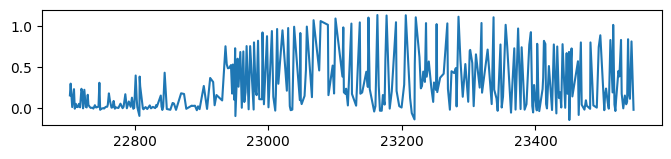

In [105]:
# Set up for Least Squares Deconvolution
modelfn = f'{datdir}/lte015-5.0-0.0a+0.0.BT-Settl.spec.7.fits'
pmod = os.path.split(modelfn)[1].replace('BT-Settl.spec.7.fits', '_dao').replace('.',',')
f_linelist   = f'{datdir}{pmod}_edited.clineslsd'
# Load the LSD files:
(lineloc, lineew, linespec) = dao.getlines(f_linelist)
plt.figure(figsize=(8,1.5))
plt.plot(lineloc, lineew) # line locations, line equvalent widths

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 8499                                                  
CRPIX1  =                    1 / Reference pixel                                
CRVAL1  =    22700.09999999999 / Coordinates at reference pixel                 
CDELT1  =   0.1000000000000012 / Coordinate increment per pixel                 
CTYPE1  = 'LINEAR  '           / Units of coordinate                            

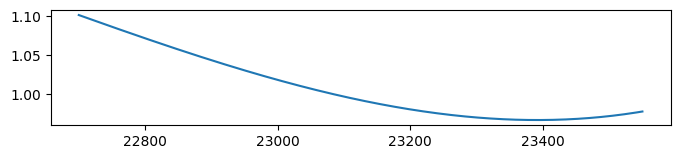

In [106]:
f_pspec      = f'{datdir}{pmod}.fits'
f_pspec_cont = f'{datdir}{pmod}C.fits'
pspec_cont = fits.getdata(f_pspec_cont) 
hdr_pspec_cont = fits.getheader(f_pspec_cont)
wspec = hdr_pspec_cont['crval1'] + np.arange(pspec_cont.size)*hdr_pspec_cont['cdelt1']
spline = interpolate.UnivariateSpline(wspec, pspec_cont, s=0.0, k=1.0) #set up interpolation over the continuum measurement
plt.figure(figsize=(8,1.5))
plt.plot(wspec, pspec_cont)
hdr_pspec_cont

In [122]:
# Compute LSD:
kerns = np.zeros((nobs, nchips, nk), dtype=float)
modkerns = np.zeros((nobs, nchips, nk), dtype=float)

### In this scheme, run LSD separately for each frame's wavelength solution:
for jj in range(nchips): # EB: chip 0-3
    for kk in range(nobs): # EB: frame 0-13
        # EB: create delta-function line spectrum from wavelength grid, list of line locations, list of equivalent widths
        deltaspec = ns.linespec(lineloc*(1.+9e-5), lineew, chiplams[:,jj].mean(0), verbose=False, cont=spline(chiplams[:,jj].mean(0)))
        # lines shifted to rv by 1+9e-5

        # EB: DSA=Difference Spectral Analysis. Match given spectra to reference spectra
        m,kerns[kk,jj],b,c = dia.dsa(deltaspec, obs1[kk,jj], nk)#/chipcors[kk,jj], nk)
        m,modkerns[kk,jj],b,c = dia.dsa(deltaspec, chipmodnobroad[kk,jj], nk)#/chipcors[kk,jj], nk)    
		#EB: dia.dsa returns: Response matrix, kernel used in convolution, background offset, chisquared of fit
		#EB: only the kernels are used from here on     

Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...
Singular matrix: det(U) < tol.  Using pseudoinverse...


KeyboardInterrupt: 

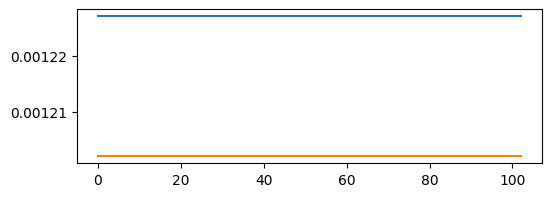

In [119]:
plt.figure(figsize=(6,2))
plt.plot(kerns[0,1])
plt.plot(modkerns[0,1])

In [10]:
# Compute LSD velocity grid:
dbeta = np.diff(chiplams).mean()/chiplams.mean() # EB: np.diff returns array containing the difference between elements of the array provided. so dbeta will be mean difference/mean value.
dx = -dbeta * np.arange(np.floor(-nk/2.+.5), np.floor(nk/2.+.5)) # EB: edit np.arange
dv = an.c*dx / 1e3 # km/s # EB: an.c is the speed of light

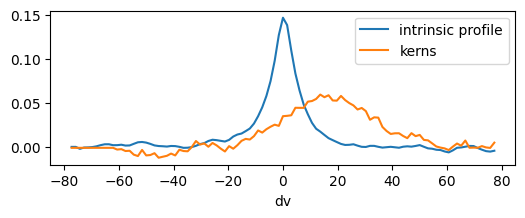

In [46]:
intrinsic_profile = modkerns[:,chips].mean(0).mean(0)
intrinsic_profile -= intrinsic_profile[0] + (intrinsic_profile[-1] - intrinsic_profile[0])/(nk - 1.) * np.arange(nk)
systematic_rv_offset = (intrinsic_profile==intrinsic_profile.max()).nonzero()[0] - (dv==0).nonzero()[0]
intrinsic_profile = np.interp(np.arange(nk), np.arange(nk) - systematic_rv_offset, intrinsic_profile)
kerns = np.array([[np.interp(np.arange(nk), np.arange(nk) - systematic_rv_offset, kerns[jj, kk]) for kk in chips] for jj in range(nobs)])
plt.figure(figsize=(6,2))
plt.plot(dv, intrinsic_profile, label="intrinsic profile")
plt.plot(dv, kerns[0,0], label="kerns")
plt.xlabel("dv")
plt.legend()

Prepare the Doppler Imaging "response matrix"

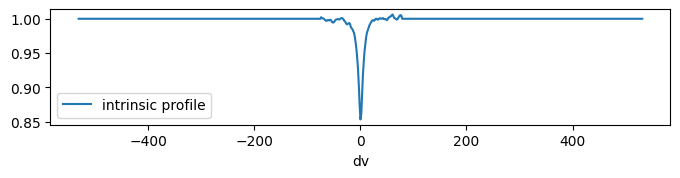

In [49]:
modIP = 1. - np.concatenate((np.zeros(300), intrinsic_profile, np.zeros(300)))
modDV = - np.arange(np.floor(-modIP.size/2.+.5), np.floor(modIP.size/2.+.5)) * dbeta * an.c / 1e3
flineSpline2 = interpolate.UnivariateSpline(modDV[::-1], modIP[::-1], k=1., s=0.)
plt.figure(figsize=(8,1.5))
plt.plot(modDV, modIP, label="intrinsic profile")
plt.xlabel("dv")
plt.legend()

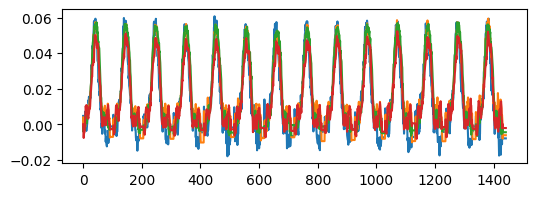

In [59]:
plt.figure(figsize=(6,2))
for jj in range(4):
    plt.plot(kerns[:,jj,:].ravel())

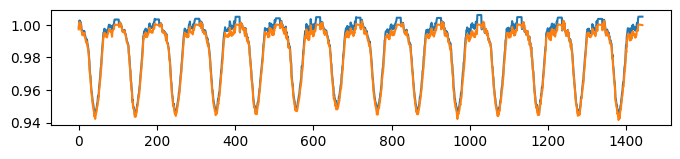

In [50]:
# XC: concatenate the kerns of 14 obs and average over the 4 orders
observation = 1. - kerns[:,chips].mean(axis=1).ravel()
observation_norm = observation.copy()
for ii in range(nobs): # EB: frame 0-13
    i0, i1 = ii*nk, (ii+1)*nk # EB: nk is the number of pixels in LSD computation on this run through
    inds = np.concatenate((np.arange(i0, i0+7), np.arange(i1-7, i1)))
    continuumfit = np.polyfit(inds, observation_norm[inds], 1)
    observation_norm[i0:i1] /= np.polyval(continuumfit, np.arange(i0, i1))
plt.figure(figsize=(8,1.5))
plt.plot(observation)
plt.plot(observation_norm)

Start the Imaging Analysis

In [14]:
nx = nlat*nlon
dime.setup(observation_norm.size, nk)
flatguess = 100*np.ones(nx)
bounds = [(1e-6, 300)]*nx
allfits = []

In [62]:
# initialize Doppler map object
mmap = ELL_map.map(nlat=nlat, nlon=nlon, i=inc) #ELL_map.map returns a class object 
ncell = mmap.ncell
latlon_corners = np.array([c.corners_latlon for c in mmap.cells]) #corner coordinates
phi_corner = latlon_corners[:,1,:]
theta_corner = latlon_corners[:,0,:]

Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.


/Users/spacegrey/workspace/dopplerimg/code/doppler/ELL_map_class.py:409: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(i)**2 / np.tan(self.corners_latlon[0,ii])**2)


Compute the "Response Matrix" of Vogt 1987:

In [17]:
Rmatrix = np.zeros((ncell, nobs*dv.size), dtype=np.float32) 

for kk, rot in enumerate(phase):
	speccube = np.zeros((ncell, dv.size), dtype=np.float32) 
	this_map = ELL_map.map(nlat=nlat, nlon=nlon, i=inc, deltaphi=-rot) #ELL_map.map returns a class object 
	
	this_doppler = 1. + vsini*this_map.visible_rvcorners.mean(1)/an.c/np.cos(inc)
	good = (this_map.projected_area>0) * np.isfinite(this_doppler)
	for ii in good.nonzero()[0]:
		speccube[ii,:] = flineSpline2(dv + (this_doppler[ii]-1)*an.c/1000.)
		#speccube[ii,:] = flineSpline(lamdv / this_doppler[ii])
	limbdarkening = (1. - LLD) + LLD * this_map.mu
	Rblock = speccube * ((limbdarkening*this_map.projected_area).reshape(this_map.ncell, 1)*np.pi/this_map.projected_area.sum())
	Rmatrix[:,dv.size*kk:dv.size*(kk+1)] = Rblock

flatmodel = dime.normalize_model(np.dot(flatguess, Rmatrix), nk)

if len(allfits)==0:  # Properly scale measurement weights:
    minfm = flatmodel.min()
    cutoffval = 1. - (1. - minfm) / 22.
    w_observation = (flatmodel < cutoffval).astype(float) / np.median(kerns[:,chips].mean(1).std(0))**2
        # Scale the observations to match the model's equivalent width:
    out, eout = an.lsq((observation_norm, np.ones(nobs*nk)), flatmodel, w=w_observation)
    sc_observation_norm = observation_norm * out[0] + out[1]
    fitargs = (sc_observation_norm, w_observation, Rmatrix, 0)
    perfect_fit = an.gfit(dime.entropy_map_norm_sp, flatguess, fprime=dime.getgrad_norm_sp, args=fitargs, ftol=ftol, disp=1, maxiter=1e4, bounds=bounds)
    
    perfect_model = dime.normalize_model(np.dot(perfect_fit[0], Rmatrix), nk)
    w_observation /=  w_observation.max() * (sc_observation_norm - perfect_model)[w_observation>0].std()**2

Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fix this.
Non-finite projected corners; need to fi

In [18]:
fitargs = (sc_observation_norm, w_observation, Rmatrix, alpha)
bfit = an.gfit(dime.entropy_map_norm_sp, flatguess, fprime=dime.getgrad_norm_sp, args=fitargs, ftol=ftol, disp=1, maxiter=1e4, bounds=bounds)
allfits.append(bfit)
bestparams = bfit[0]
model_observation = dime.normalize_model(np.dot(bestparams, Rmatrix), nk)
metric, chisq, entropy = dime.entropy_map_norm_sp(bestparams, *fitargs, retvals=True)

# reshape into grid
bestparamgrid = np.reshape(bestparams, (-1, nlon))

fits.writeto('map_CRIRES_4chips_25Nov22.fits', bestparamgrid, overwrite=True)

  ITER       METRIC         FACTOR             DMETRIC
      1   -29617.425547   1.50000e+00   -7.452e-01
      2   -29618.505172   2.25000e+00   -1.080e+00
      3   -29620.042248   3.37500e+00   -1.537e+00
      4   -29622.174018   5.06250e+00   -2.132e+00
      5   -29625.016440   7.59375e+00   -2.842e+00
      6   -29628.589089   1.13906e+01   -3.573e+00
      7   -29632.701395   1.70859e+01   -4.112e+00
      8   -29636.866056   2.56289e+01   -4.165e+00
      9   -29640.416856   3.84434e+01   -3.551e+00
     10   -29642.965675   5.76650e+01   -2.549e+00
     11   -29644.762319   8.64976e+01   -1.797e+00
     12   -29646.244618   1.29746e+02   -1.482e+00
     13   -29647.703383   1.94620e+02   -1.459e+00
     14   -29649.260574   2.91929e+02   -1.557e+00
     15   -29650.693317   4.37894e+02   -1.433e+00
     16   -29650.693317   2.18947e+02   -1.433e+00
     17   -29651.000594   2.18947e+02   -3.073e-01
     18   -29651.000594   1.09473e+02   -3.073e-01
     19   -29651.116197   1

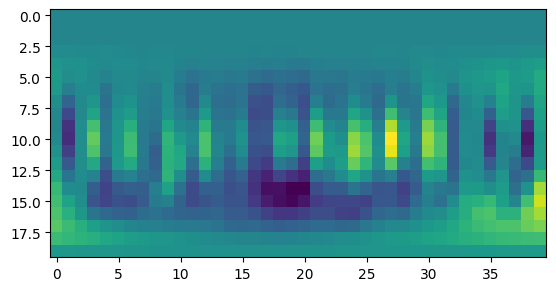

In [19]:
plt.imshow(bestparamgrid)

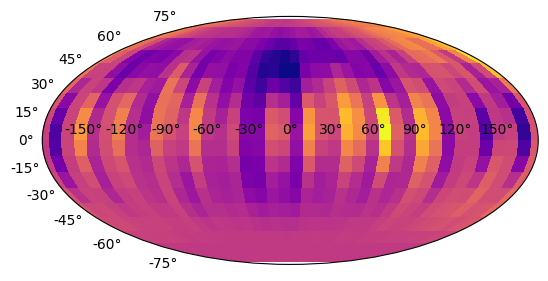

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
lon = np.linspace(-np.pi, np.pi, nlon)
lat = np.linspace(-np.pi/2., np.pi/2., nlat)
Lon,Lat = np.meshgrid(lon,lat)
im = ax.pcolormesh(Lon,Lat,bestparamgrid, cmap=plt.cm.plasma)
plt.show()

In [23]:
fig.savefig('map_WISE1049B_CRIRES_25Nov22.png')